In [ ]:
from vgg16_model import VGG16Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path
from livelossplot import PlotLossesKeras
import numpy as np
import os
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import json

IMG_SIZE = (224,224)
DATASET_NAME = "train_test_datasets"
SPLITTED_IMG_SET = Path(DATASET_NAME)
TRAIN_DIR = SPLITTED_IMG_SET / "train"
TEST_DIR = SPLITTED_IMG_SET /"test"
VAL_DIR = SPLITTED_IMG_SET / "val"
IMGS_CTGS = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]
CLASSIFICATION_PERFORMANCE_PATH = Path("classifier_results")
CONFUSION_MATRIX_PATH = CLASSIFICATION_PERFORMANCE_PATH /'confusion_matrix.png'
BATCH_SIZE = 64
N_EPOCHS = 15
CLASS_MODE = "categorical"
MODEL_NAME = "vgg16_model.hdf5"


In [ ]:
train_generator = ImageDataGenerator(rotation_range=90, 
                                        brightness_range=[0.1, 0.7],
                                        width_shift_range=0.5, 
                                        height_shift_range=0.5,
                                        horizontal_flip=True, 
                                        vertical_flip=True,
                                        validation_split=0.15,
                                        preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
traingen = train_generator.flow_from_directory(TRAIN_DIR,
                                                target_size=IMG_SIZE,
                                                class_mode= CLASS_MODE,
                                                classes=IMGS_CTGS,
                                                subset='training',
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                seed=42)

validgen = train_generator.flow_from_directory(VAL_DIR,
                                                target_size=IMG_SIZE,
                                                class_mode=CLASS_MODE,
                                                classes=IMGS_CTGS,
                                                subset='validation',
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                seed=42)

testgen = test_generator.flow_from_directory(TEST_DIR,
                                                target_size=IMG_SIZE,
                                                class_mode=CLASS_MODE,
                                                classes=IMGS_CTGS,
                                                batch_size=1,
                                                shuffle=False,
                                                seed=42)

vgg_model = VGG16Model().create_model()

plot_loss_1 = PlotLossesKeras()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath=MODEL_NAME,
                                    save_best_only=True,
                                    verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                            patience=10,
                            restore_best_weights=True,
                            mode='min')


vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=N_EPOCHS,
                            validation_data=validgen,
                            steps_per_epoch=traingen.samples // BATCH_SIZE,
                            validation_steps=validgen.samples // BATCH_SIZE,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)
vgg_model.save(MODEL_NAME)

In [15]:
vgg_model.load_weights(MODEL_NAME)
true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)
vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

47/47 [==============================] - 2s 30ms/step
VGG16 Model Accuracy without Fine-Tuning: 97.87%


47/47 [==============================] - 1s 30ms/step


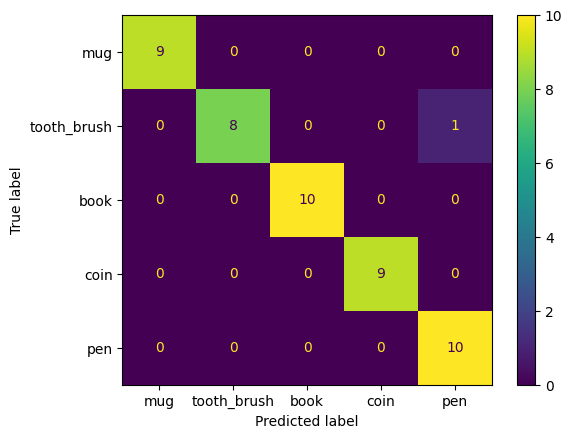

In [23]:
results = {}
categories = os.listdir(TEST_DIR)

true_classes = testgen.classes
class_indices = testgen.class_indices
vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

average = 'macro'
cm = confusion_matrix(true_classes, vgg_pred_classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = categories)
cm_display.plot()
plt.savefig(CONFUSION_MATRIX_PATH)

ctg_results = classification_report(true_classes, vgg_pred_classes, target_names=categories, output_dict=True)
with open("vgg16_classifier.json", 'w') as f:
    json.dump(ctg_results, f, indent = 4)